# Session 4: Bayesian Model Evaluation and Workflow

In this session, we will learn to evaluate the quality of our models using statistical and visual diagnostics. We'll also discuss a comprehensive Bayesian workflow that promotes model development through an iterative process.

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as st
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import warnings
warnings.simplefilter("ignore")

RANDOM_SEED = 20090425

## MCMC Output Processing and Model Checking with ArviZ

ArviZ is a Python package for exploratory analysis of Bayesian models. It includes functions for posterior analysis, model checking, comparison and diagnostics. ArviZ is designed to work with output from a wide range of Bayesian inference libraries, including PyMC, emcee, Stan, Pyro, and TensorFlow Probability.

ArviZ is built on top of the popular libraries xarray and matplotlib. It is also built with the same design principles as PyMC, so if you are familiar with PyMC, you will find ArviZ easy to use.

### Example: Effect of coaching on SAT scores

This example was taken from Gelman *et al.* (2013):

> A study was performed for the Educational Testing Service to analyze the effects of special coaching programs on test scores. Separate randomized experiments were performed to estimate the effects of coaching programs for the SAT-V (Scholastic Aptitude Test- Verbal) in each of eight high schools. The outcome variable in each study was the score on a special administration of the SAT-V, a standardized multiple choice test administered by the Educational Testing Service and used to help colleges make admissions decisions; the scores can vary between 200 and 800, with mean about 500 and standard deviation about 100. The SAT examinations are designed to be resistant to short-term efforts directed specifically toward improving performance on the test; instead they are designed to reflect knowledge acquired and abilities developed over many years of education. Nevertheless, each of the eight schools in this study considered its short-term coaching program to be successful at increasing SAT scores. Also, there was no prior reason to believe that any of the eight programs was more effective than any other or that some were more similar in effect to each other than to any other.

We are given the estimated coaching effects (`y`) and their sampling variances (`s`). The estimates were obtained by independent experiments, with relatively large sample sizes (over thirty students in each school), so you it can be assumed that they have approximately normal sampling distributions with known variances.

In [97]:
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
s = np.array([15, 10, 16, 11, 9, 11, 10, 18])
schools = np.array(
    [
        "Choate",
        "Deerfield",
        "Phillips Andover",
        "Phillips Exeter",
        "Hotchkiss",
        "Lawrenceville",
        "St. Paul's",
        "Mt. Hermon",
    ]
)

with pm.Model(coords={'school': schools}) as schools_model:
    
    mu = pm.Normal("mu", 0, sigma=1e6)
    tau = pm.HalfCauchy("tau", 5)

    theta = pm.Normal("theta", mu, sigma=tau, dims='school')

    obs = pm.Normal("obs", theta, sigma=s, observed=y)

In [98]:
with schools_model:
    # Model fitting
    schools_trace = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    # Posterior predictive sampling
    pm.sample_posterior_predictive(schools_trace, extend_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 273 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [obs]


Output()

## Model Checking

The final step in Bayesian computation is model checking, in order to ensure that inferences derived from your sample are valid

There are **two components** to model checking:

1. Convergence diagnostics
2. Goodness of fit

Convergence diagnostics are intended to detect **lack of convergence** in the Markov chain Monte Carlo sample; it is used to ensure that you have not halted your sampling too early. However, a converged model is not guaranteed to be a good model. 

The second component of model checking, goodness of fit, is used to check the **internal validity** of the model, by comparing predictions from the model to the data used to fit the model. 

## Convergence Diagnostics

Valid inferences from sequences of MCMC samples are based on the
assumption that the samples are derived from the true posterior
distribution of interest. Theory guarantees this condition as the number
of iterations approaches infinity. It is important, therefore, to
determine the **minimum number of samples** required to ensure a reasonable
approximation to the target posterior density. Unfortunately, no
universal threshold exists across all problems, so convergence must be
assessed independently each time MCMC estimation is performed. The
procedures for verifying convergence are collectively known as
*convergence diagnostics*.

There are a handful of easy-to-use methods for checking convergence. Since you cannot prove convergence, but only show lack of convergence, there is no single method that is foolproof. So, its best to look at a suite of diagnostics together. 

We will cover the canonical set of checks:

- Sampler statistics
- Variable plotting
- Divergences
- R-hat
- Effective Sample Size

## Sampler Statistics

When checking for convergence or when debugging a badly behaving sampler, it is often helpful to take a closer look at what the sampler is doing. For this purpose some samplers export statistics for each generated sample.

NUTS provides several metrics related to the performance of the sampler.

In [99]:
schools_trace.sample_stats

<xarray.Dataset> Size: 496kB
Dimensions:                (chain: 4, draw: 1000)
Coordinates:
  * chain                  (chain) int64 32B 0 1 2 3
  * draw                   (draw) int64 8kB 0 1 2 3 4 5 ... 995 996 997 998 999
Data variables: (12/17)
    smallest_eigval        (chain, draw) float64 32kB nan nan nan ... nan nan
    largest_eigval         (chain, draw) float64 32kB nan nan nan ... nan nan
    tree_depth             (chain, draw) int64 32kB 4 4 5 4 4 5 ... 4 4 4 4 4 4
    step_size              (chain, draw) float64 32kB 0.274 0.274 ... 0.4831
    acceptance_rate        (chain, draw) float64 32kB 0.8556 0.9987 ... 0.9847
    diverging              (chain, draw) bool 4kB False False ... False False
    ...                     ...
    n_steps                (chain, draw) float64 32kB 15.0 15.0 ... 15.0 15.0
    lp                     (chain, draw) float64 32kB -70.17 -68.26 ... -74.12
    energy_error           (chain, draw) float64 32kB -0.01168 ... 0.01562
    energy                 (chain, draw) float64 32kB 73.49 73.39 ... 80.05
    step_size_bar          (chain, draw) float64 32kB 0.2131 0.2131 ... 0.2822
    perf_counter_start     (chain, draw) float64 32kB 1.292e+04 ... 1.292e+04
Attributes:
    created_at:                 2025-05-20T22:56:39.028650+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.22.0
    sampling_time:              1.34293794631958
    tuning_steps:               1000

The sample statistics variables are defined as follows:

- `process_time_diff`: The time it took to draw the sample, as defined by the python standard library time.process_time. This counts all the CPU time, including worker processes in BLAS and OpenMP.

- `step_size`: The current integration step size.

- `diverging`: (boolean) Indicates the presence of leapfrog transitions with large energy deviation from starting and subsequent termination of the trajectory. "large" is defined as `max_energy_error` going over a threshold.

- `lp`: The joint log posterior density for the model (up to an additive constant).

- `energy`: The value of the Hamiltonian energy for the accepted proposal (up to an additive constant).

- `energy_error`: The difference in the Hamiltonian energy between the initial point and the accepted proposal.

- `perf_counter_diff`: The time it took to draw the sample, as defined by the python standard library time.perf_counter (wall time).

- `perf_counter_start`: The value of time.perf_counter at the beginning of the computation of the draw.

- `n_steps`: The number of leapfrog steps computed. It is related to `tree_depth` with `n_steps <= 2^tree_dept`.

- `max_energy_error`: The maximum absolute difference in Hamiltonian energy between the initial point and all possible samples in the proposed tree.

- `acceptance_rate`: The average acceptance probabilities of all possible samples in the proposed tree.

- `step_size_bar`: The current best known step-size. After the tuning samples, the step size is set to this value. This should converge during tuning.

- `tree_depth`: The number of tree doublings in the balanced binary tree.

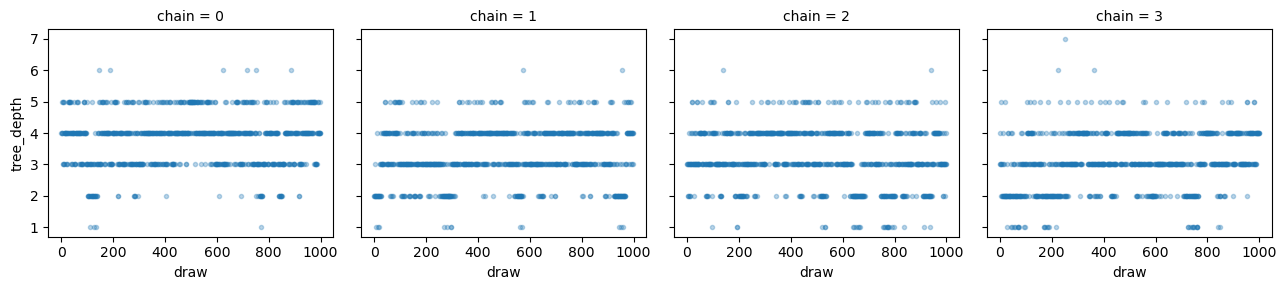

In [100]:
schools_trace.sample_stats["tree_depth"].plot(col="chain", ls="none", marker=".", alpha=0.3);

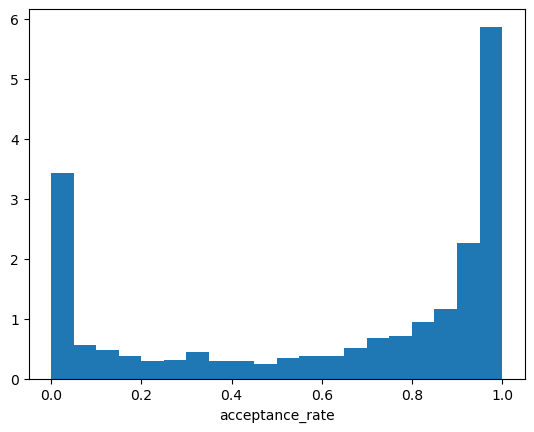

In [101]:
schools_trace.sample_stats["acceptance_rate"].plot.hist(bins=20, density=True);

## Output Visualization with ArviZ

[ArviZ](https://arviz-devs.github.io/arviz/) is a Python package for exploratory analysis of Bayesian models. It includes functions for posterior analysis, model checking, comparison and diagnostics and is desingefd to work with a range of Bayesian inference libraries (not just PyMC).

ArviZ is built on top of the popular libraries xarray and matplotlib. It is also built with the same design principles as PyMC, so if you are familiar with PyMC, you will find ArviZ easy to use.

## Traceplot 

Perhaps the most-used ArviZ plot is the traceplot, obtained via the `plot_trace` function. This is a simple plot that is a good quick check to make sure nothing is obviously wrong, and is usually the first diagnostic step you will take. You've seen these already: just the time series of samples for an individual variable.

The `plot_trace` function from ArViZ by default generates a kernel density plot and a trace plot, with a different color for each chain of the simulation.

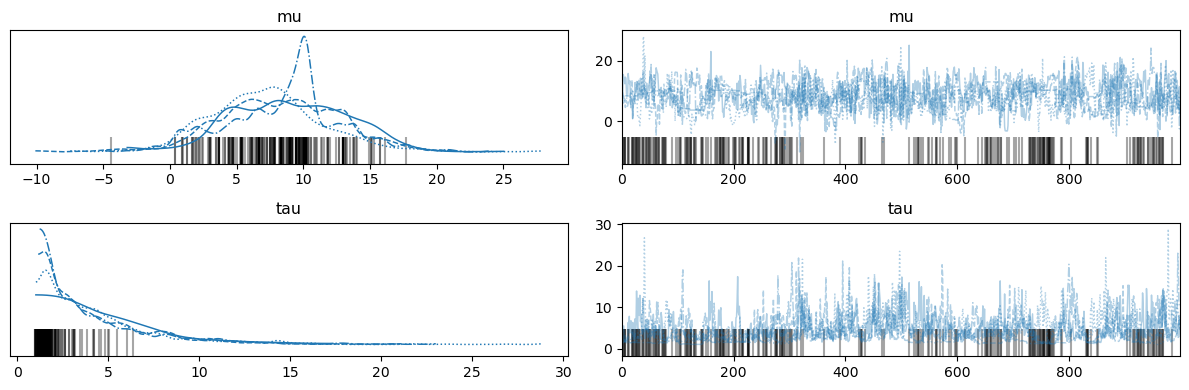

In [102]:
az.plot_trace(schools_trace, var_names=['mu', 'tau']);
plt.tight_layout();

Let's look at a trace plot for a more complex example of a hierarchical model:

In [103]:
# Import radon data
radon_data = pd.read_csv('../data/radon.csv', index_col=0)

counties = radon_data.county.unique()
n_counties = counties.shape[0]
county = radon_data.county_code.values
log_radon = radon_data.log_radon.values
floor_measure = radon_data.floor.values
log_uranium = np.log(radon_data.Uppm.values)
county_lookup = dict(zip(counties, np.arange(n_counties)))

In [104]:
with pm.Model() as varying_slope:
    
    # Priors
    mu_b = pm.Normal('mu_b', mu=0., sigma=10)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    # Common intercepts
    a = pm.Normal('a', mu=0., sigma=10)
    # Random slopes
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_counties)
    
    # Model error
    sigma_y = pm.HalfCauchy('sigma_y',5)
    
    # Expected value
    y_hat = a + b[county] * floor_measure
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon)

In [105]:
with varying_slope:
    varying_slope_trace = pm.sample(cores=2, tune=1000, random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_b, sigma_b, a, b, sigma_y]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


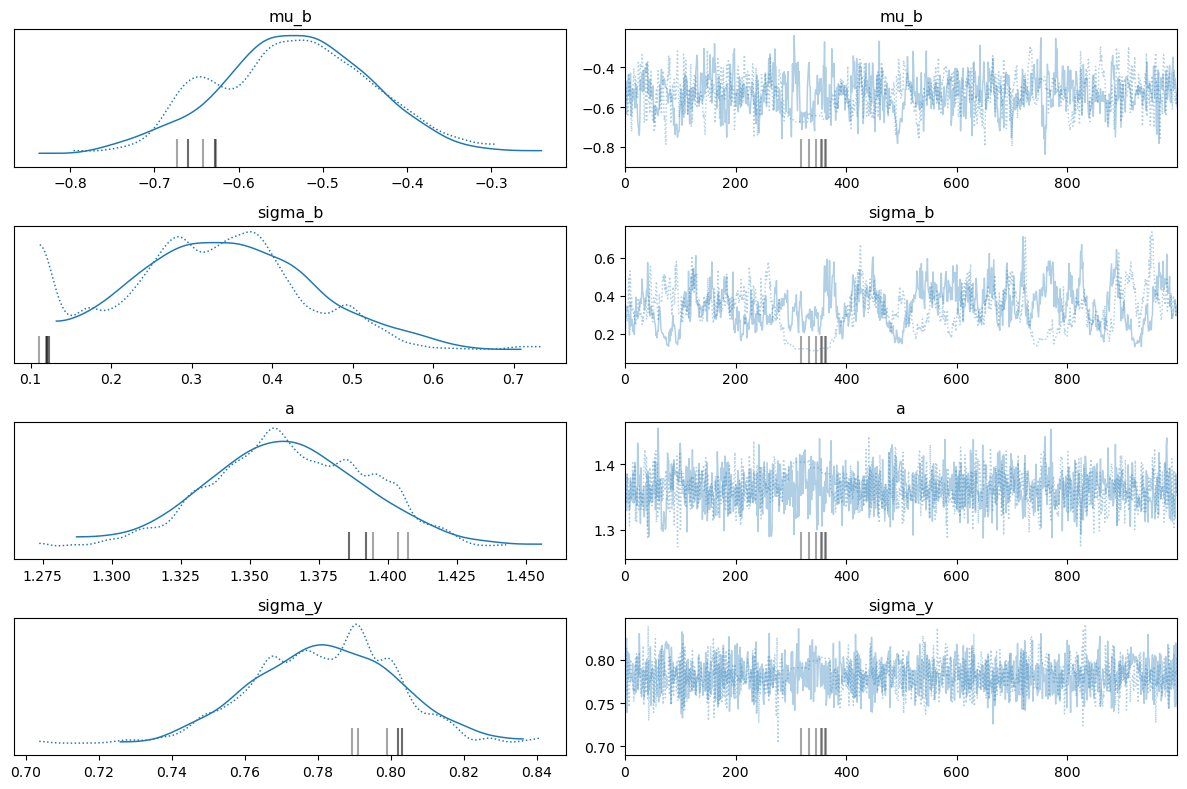

In [106]:
az.plot_trace(varying_slope_trace, var_names=['mu_b', 'sigma_b', 'a', 'sigma_y']);
plt.tight_layout();

## Divergences

As we have seen, Hamiltonian Monte Carlo (and NUTS) performs numerical integration in order to explore the posterior distribution of a model. When the integration goes wrong, it can go dramatically wrong. 

For example, here are some Hamiltonian trajectories on the distribution of two correlated variables. Can you spot the divergent path?

![divering HMC](images/diverging_hmc.png)

The reason that this happens is that there may be parts of the posterior which are **hard to explore** for geometric reasons. Two ways of solving divergences are

1. **Set a higher "target accept" rate**: Similarly (but not the same) as for Metropolis-Hastings, larger integrator steps lead to lower acceptance rates. A higher `target_accept` will generally cause a smaller step size, and more accurate integration.
2. **Reparametrize**: If you can write your model in a different way that has the same joint probability density, you might do thpt. A lot of work is being done to automate this, since it requires careful work, and one goal of a probabilistic programming language is to iterate quickly. See [Hoffmann, Johnson, Tran (2018)](https://arxiv.org/abs/1811.11926), [Gorinova, Moore, Hoffmann (2019)](https://arxiv.org/abs/1906.03028).

You should be wary of a trace that contains many divergences (particularly those clustered in particular regions of the parameter space), and give thought to how to fix them.

### Divergence example

The trajectories above are from a famous example of a difficult geometry: Neal's funnel. It is problematic because the geometry is very different in some regions of the state space relative to others. Specifically, for hierarchical models, as the scale parameter changes in size so do the values of the parameters it is constraining. When the variance is close to zero, the parameter space is very constrained relative to the majority of the support.

In [107]:
def neals_funnel(dims=2):
    with pm.Model() as funnel:
        v = pm.Normal('v', 0, 3)
        x_vec = pm.MvNormal('x_vec', mu=pt.zeros(dims), cov=2 * pt.exp(v) * pt.eye(dims), shape=dims)
    return funnel

with neals_funnel():
    funnel_trace = pm.sample(random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, x_vec]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 548 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


We can check for divergences and where they occur in parameter space:

In [108]:
diverging_ind = funnel_trace.sample_stats['diverging'].values[0].nonzero()
diverging_ind

(array([  0,   1,   8,   9,  11,  18,  20,  22,  24,  28,  29,  32,  34,
         37,  41,  42,  44,  46,  47,  48,  50,  51,  52,  54,  59,  60,
         61,  63,  66,  68,  70,  74,  75,  76,  79,  80,  84,  87,  88,
         90,  91,  93,  94,  97, 101, 105, 106, 113, 114, 116, 117, 120,
        122, 123, 129, 131, 133, 134, 146, 147, 150, 156, 157, 158, 161,
        165, 168, 169, 172, 173, 174, 176, 178, 180, 181, 182, 183, 184,
        185, 186, 188, 194, 195, 199, 201, 204, 208, 213, 220, 221, 223,
        224, 230, 231, 232, 233, 237, 238, 239, 244, 248, 250, 252, 255,
        260, 268, 277, 284, 289, 297, 300, 301, 304, 305, 311, 313, 320,
        322, 328, 335, 343, 349, 351, 356, 357, 364, 365, 373, 386, 390,
        391, 392, 394, 396, 400, 402, 403, 408, 410, 417, 420, 423, 425,
        430, 433, 434, 453, 454, 456, 460, 461, 462, 466, 469, 471, 473,
        480, 483, 485, 487, 497, 589, 672, 683, 862, 941]),)

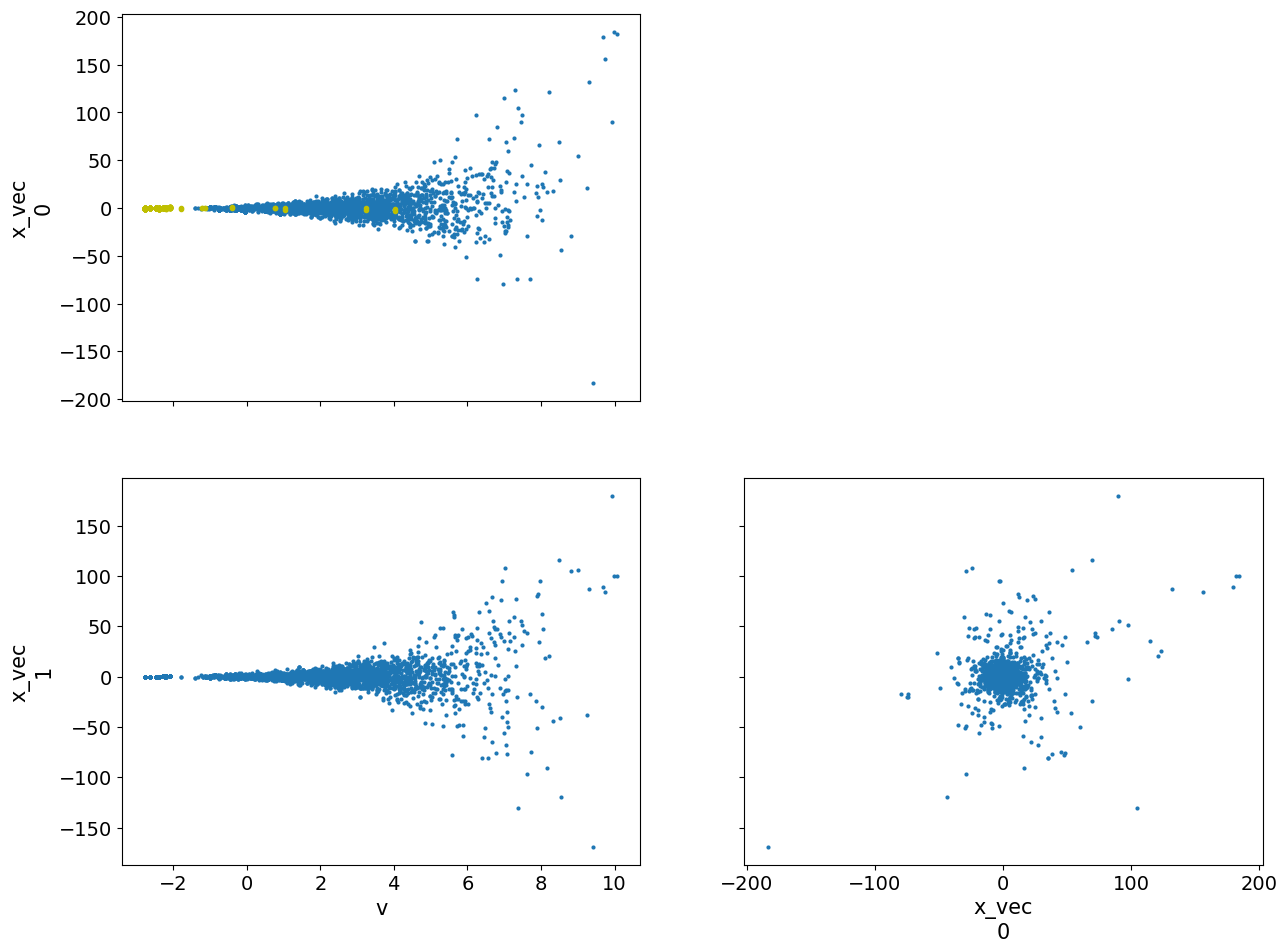

In [109]:
ax = az.plot_pair(funnel_trace)
ax[0][0].plot(funnel_trace.posterior['v'].sel(chain=0).values[diverging_ind], 
              funnel_trace.posterior['x_vec'].sel(chain=0).values[diverging_ind].squeeze(), 'y.');

### Solution: Non-centered Parameterization

One solution to divergences in hierarchical models is to use a non-centered parameterization. This means reparameterizing the model to make sampling more efficient.

For the radon model we saw earlier, we can implement a non-centered version:

In [110]:
with pm.Model() as varying_slope_noncentered:
    
    # Priors
    mu_b = pm.Normal('mu_b', mu=0., sigma=10)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    # Common intercepts
    a = pm.Normal('a', mu=0., sigma=10)
    
    # Non-centered random slopes
    # Centered: b = Normal('b', mu_b, sigma=sigma_b, shape=counties)
    z = pm.Normal('z', mu=0, sigma=1, shape=n_counties)
    b = pm.Deterministic("b", mu_b + z * sigma_b)
    
    # Model error
    sigma_y =pm.HalfCauchy('sigma_y',5)
    
    # Expected value
    y_hat = a + b[county] * floor_measure
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon)

In [111]:
with varying_slope_noncentered:
    noncentered_trace = pm.sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_b, sigma_b, a, z, sigma_y]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [112]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Extract data
x = pd.Series(noncentered_trace.posterior['b'].sel(chain=0)[:, 75], name='slope')
y = pd.Series(noncentered_trace.posterior['sigma_b'].sel(chain=0), name='slope group variance')

# Convert to numpy arrays for easier handling
x_values = x.values
y_values = y.values

# Create figure with 2 rows and 2 columns for joint plot
fig = make_subplots(
    rows=2, 
    cols=2,
    column_widths=[0.8, 0.2],
    row_heights=[0.2, 0.8],
    vertical_spacing=0.02,
    horizontal_spacing=0.02,
    specs=[
        [{"type": "histogram"}, {"type": "scatter"}],
        [{"type": "scatter"}, {"type": "histogram"}]
    ]
)

# Add scatter plot in main area (row 2, col 1)
fig.add_trace(
    go.Scatter(
        x=x_values,
        y=y_values,
        mode='markers',
        marker=dict(
            color='blue',
            size=5,
            opacity=0.6
        ),
        showlegend=False
    ),
    row=2, col=1
)

# Add x-histogram (row 1, col 1)
fig.add_trace(
    go.Histogram(
        x=x_values,
        marker=dict(color='blue'),
        nbinsx=30,
        showlegend=False
    ),
    row=1, col=1
)

# Add y-histogram (row 2, col 2)
fig.add_trace(
    go.Histogram(
        y=y_values,
        marker=dict(color='blue'),
        nbinsy=30,
        showlegend=False
    ),
    row=2, col=2
)

# Update layout
fig.update_layout(
    height=600,
    width=600,
    title='Joint Distribution of Slope and Slope Group Variance',
    xaxis2=dict(title='slope'),
    yaxis2=dict(title='slope group variance', range=[0, 0.7])
)

# Update the empty plot
fig.update_xaxes(showticklabels=False, row=1, col=2)
fig.update_yaxes(showticklabels=False, row=1, col=2)

fig.show()

## Potential Scale Reduction: $\hat{R}$

Roughly, $\hat{R}$ (*R-Hat*, or the *Gelman-Rubin statistic*) is the ratio of between-chain variance to within-chain variance. This diagnostic uses multiple chains to
check for lack of convergence, and is based on the notion that if
multiple chains have converged, by definition they should appear very
similar to one another; if not, one or more of the chains has failed to
converge.

$\hat{R}$ uses an analysis of variance approach to
assessing convergence. That is, it calculates both the between-chain
variance (B) and within-chain variance (W), and assesses whether they
are different enough to worry about convergence. Assuming $m$ chains,
each of length $n$, quantities are calculated by:

$$\begin{align}B &= \frac{n}{m-1} \sum_{j=1}^m (\bar{\theta}_{.j} - \bar{\theta}_{..})^2 \\
W &= \frac{1}{m} \sum_{j=1}^m \left[ \frac{1}{n-1} \sum_{i=1}^n (\theta_{ij} - \bar{\theta}_{.j})^2 \right]
\end{align}$$

for each scalar estimand $\theta$. Using these values, an estimate of
the marginal posterior variance of $\theta$ can be calculated:

$$\hat{\text{Var}}(\theta | y) = \frac{n-1}{n} W + \frac{1}{n} B$$

Assuming $\theta$ was initialized to arbitrary starting points in each
chain, this quantity will overestimate the true marginal posterior
variance. At the same time, $W$ will tend to underestimate the
within-chain variance early in the sampling run. However, in the limit
as $n \rightarrow 
\infty$, both quantities will converge to the true variance of $\theta$.
In light of this, $\hat{R}$ monitors convergence using
the ratio:

$$\hat{R} = \sqrt{\frac{\hat{\text{Var}}(\theta | y)}{W}}$$

This is called the **potential scale reduction**, since it is an estimate of
the potential reduction in the scale of $\theta$ as the number of
simulations tends to infinity. In practice, we look for values of
$\hat{R}$ close to one (say, less than 1.1) to be confident that a
particular estimand has converged. 

In [113]:
az.summary(noncentered_trace, var_names=['mu_b', 'sigma_b', 'a', 'sigma_y'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_b,-0.535,0.088,-0.691,-0.354,0.002,0.002,1410.0,902.0,1.00
sigma_b,0.307,0.119,0.077,0.532,0.005,0.003,583.0,701.0,1.00
a,1.363,0.027,1.313,1.413,0.001,0.001,2008.0,1123.0,1.01
sigma_y,0.782,0.020,0.749,0.821,0.000,0.001,2160.0,1257.0,1.00


## Effective Sample Size

In general, samples drawn from MCMC algorithms will be autocorrelated. Unless the autocorrelation is very severe, this is not a big deal, other than the fact that autocorrelated chains may require longer sampling in order to adequately characterize posterior quantities of interest. The calculation of autocorrelation is performed for each lag $i=1,2,\ldots,k$ (the correlation at lag 0 is, of course, 1) by: 

$$\hat{\rho}_i = 1 - \frac{V_i}{2\hat{\text{Var}}(\theta | y)}$$

where $\hat{\text{Var}}(\theta | y)$ is the same estimated variance as calculated for the Gelman-Rubin statistic, and $V_i$ is the variogram at lag $i$ for $\theta$:

$$\text{V}_i = \frac{1}{m(n-i)}\sum_{j=1}^m \sum_{k=i+1}^n (\theta_{jk} - \theta_{j(k-i)})^2$$

This autocorrelation can be visualized using the `plot_autocorr` function in ArviZ:

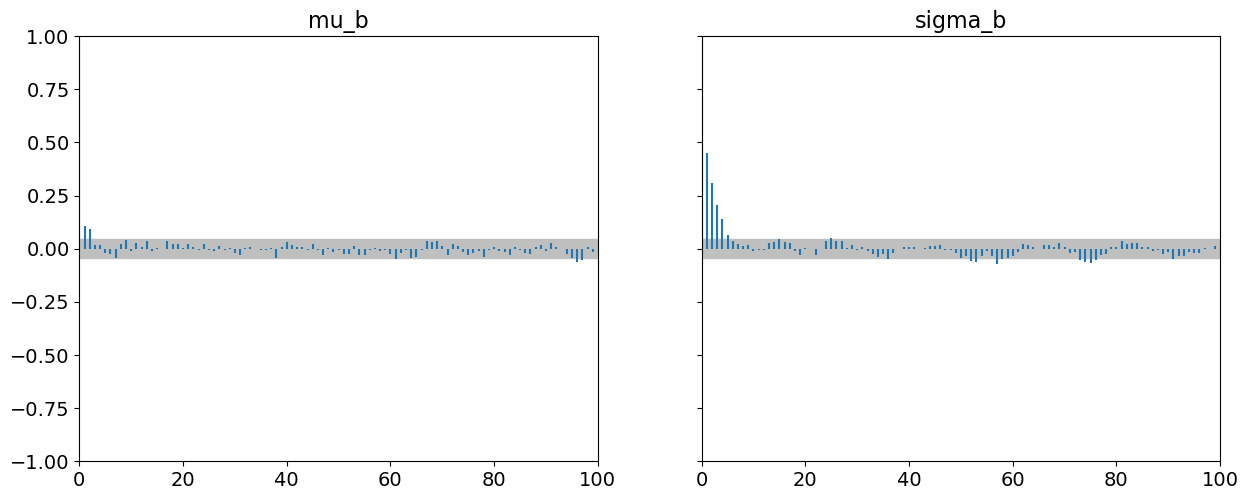

In [114]:
az.plot_autocorr(noncentered_trace, var_names=['mu_b', 'sigma_b'], combined=True);

The amount of correlation in an MCMC sample influences the **effective sample size** (ESS) of the sample. The ESS estimates how many *independent* draws contain the same amount of information as the *dependent* sample obtained by MCMC sampling.

Given a series of samples $x_j$, the empirical mean is

$$
\hat{\mu} = \frac{1}{n}\sum_{j=1}^n x_j
$$

and the variance of the estimate of the empirical mean is 

$$
\operatorname{Var}(\hat{\mu}) = \frac{\sigma^2}{n},
$$
where $\sigma^2$ is the true variance of the underlying distribution.

Then the effective sample size is defined as the denominator that makes this relationship still be true:

$$
\operatorname{Var}(\hat{\mu}) = \frac{\sigma^2}{n_{\text{eff}}}.
$$

The effective sample size is estimated using the partial sum:

$$\hat{n}_{eff} = \frac{mn}{1 + 2\sum_{i=1}^T \hat{\rho}_i}$$

where $T$ is the first odd integer such that $\hat{\rho}_{T+1} + \hat{\rho}_{T+2}$ is negative.

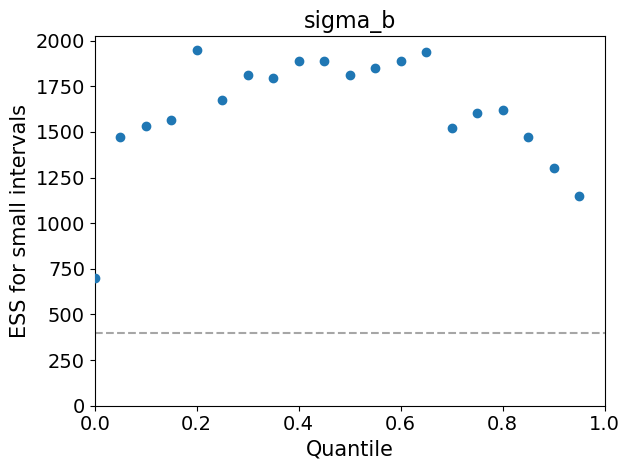

In [115]:
az.plot_ess(noncentered_trace, var_names=['sigma_b'])
plt.tight_layout();

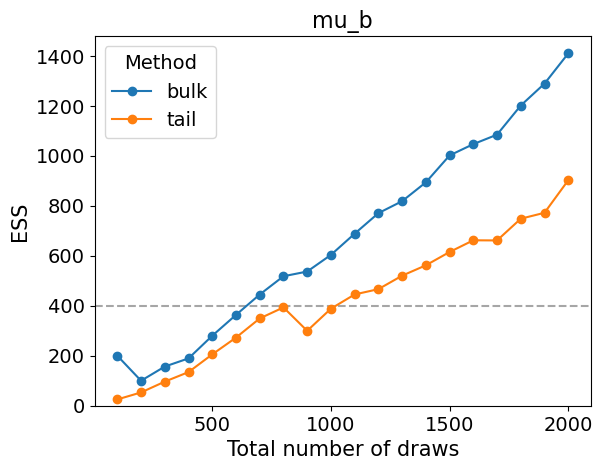

In [116]:
az.plot_ess(noncentered_trace, var_names=['mu_b'], kind='evolution');

## Bayesian Fraction of Missing Information

The Bayesian fraction of missing information (BFMI) is a measure of how hard it is to
sample level sets of the posterior at each iteration. Specifically, it quantifies **how well momentum resampling matches the marginal energy distribution**. 

$$\text{BFMI} = \frac{\mathbb{E}_{\pi}[\text{Var}_{\pi_{E|q}}(E|q)]}{\text{Var}_{\pi_{E}}(E)}$$

$$\widehat{\text{BFMI}} = \frac{\sum_{i=1}^N (E_n - E_{n-1})^2}{\sum_{i=1}^N (E_n - \bar{E})^2}$$

A small value indicates that the adaptation phase of the sampler was unsuccessful, and invoking the central limit theorem may not be valid. It indicates whether the sampler is able to *efficiently* explore the posterior distribution.

Though there is not an established rule of thumb for an adequate threshold, values close to one are optimal. Reparameterizing the model is sometimes helpful for improving this statistic.

In [117]:
az.bfmi(noncentered_trace)

array([0.77074755, 0.71376633])

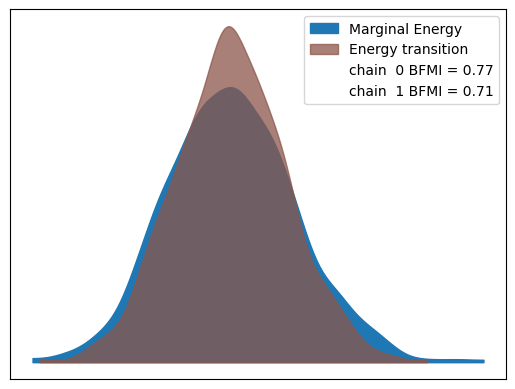

In [118]:
az.plot_energy(noncentered_trace);

## Goodness of Fit

As noted at the beginning of this section, convergence diagnostics are only the first step in the evaluation
of MCMC model outputs. It is possible for an entirely unsuitable model to converge, so additional steps are needed to ensure that the estimated model adequately fits the data. 

One intuitive way of evaluating model fit is to compare model predictions with the observations used to fit
the model. In other words, the fitted model can be used to simulate data, and the distribution of the simulated data should resemble the distribution of the actual data.

Fortunately, simulating data from the model is a natural component of the Bayesian modelling framework. Recall, from the discussion on prediction, the posterior predictive distribution:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

Here, $\tilde{y}$ represents some hypothetical new data that would be expected, taking into account the posterior uncertainty in the model parameters. 

Sampling from the posterior predictive distribution is easy in PyMC. The `sample_posterior_predictive` function draws posterior predictive samples from all of the observed variables in the model. 

In [119]:
with varying_slope_noncentered:
    pm.sample_posterior_predictive(noncentered_trace, extend_inferencedata=True)

Sampling: [y_like]


Output()

The degree to which simulated data correspond to observations can be evaluated visually. This allows for a qualitative comparison of model-based replicates and observations. If there is poor fit, the true value of the data may appear in the tails of the histogram of replicated data, while a good fit will tend to show the true data in high-probability regions of the posterior predictive distribution.

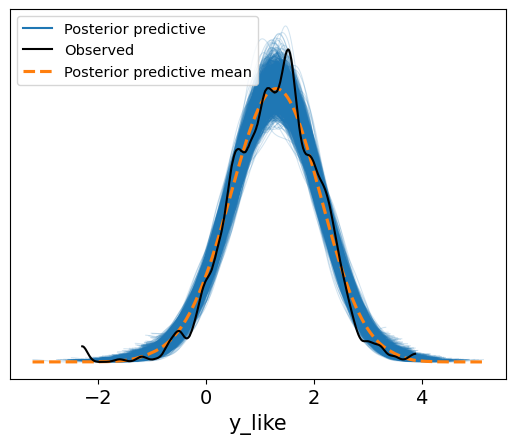

In [120]:
az.plot_ppc(noncentered_trace);

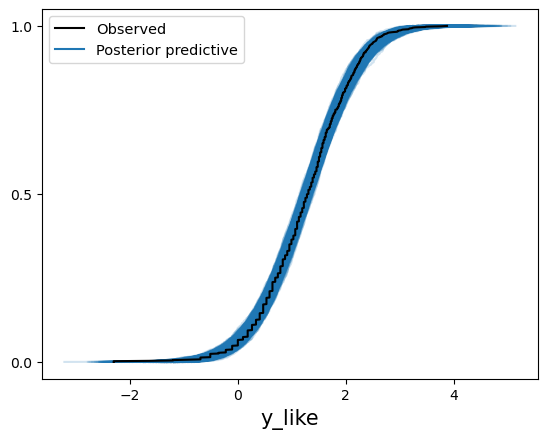

In [121]:
az.plot_ppc(noncentered_trace, kind='cumulative', mean=False);

We can also look at the predictive performance of our model by examining the residuals:

In [124]:
import plotly.graph_objects as go

# Calculate predicted values and residuals
y_pred = noncentered_trace.posterior_predictive["y_like"].mean(["chain", "draw"]).values
residuals = log_radon - y_pred

# Create scatter plot of residuals vs predicted values
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=y_pred,
        y=residuals,
        mode='markers',
        marker=dict(
            color='royalblue',
            size=8,
            opacity=0.6
        ),
        name='Residuals'
    )
)

# Add horizontal line at y=0
fig.add_shape(
    type="line",
    x0=float(y_pred.min()),
    x1=float(y_pred.max()),
    y0=0,
    y1=0,
    line=dict(
        color="red",
        width=2
    )
)

# Update layout
fig.update_layout(
    title='Residual Plot',
    xaxis_title='Predicted values',
    yaxis_title='Residuals',
    width=1000,
    height=600,
    plot_bgcolor='white',
    showlegend=False
)

fig.show()

# Bayesian Workflow

Strengths of Bayesian statistics that are critical:
* Great flexibility to quickly and iteratively build statistical models
* Offers principled way of dealing with uncertainty
* Don't just want most likely outcome but distribution of all possible outcomes
* Allows expert information to guide model by using informative priors

The Bayesian workflow consists of:
* How to go from data to a model idea
* How to find priors for your model
* How to evaluate a model
* How to iteratively improve a model
* How to forecast into the future
* How powerful generative modeling can be

## COVID-19 Case Study

Let's apply the Bayesian workflow to a real-world problem: modeling COVID-19 cases.

In [29]:
import load_covid_data

df = load_covid_data.load_data(drop_states=True, filter_n_days_100=2)
countries = df.country.unique()
n_countries = len(countries)
df = df.loc[lambda x: (x.days_since_100 >= 0)]
df.head()

,country,state,type,confirmed,critical_estimate,days_since_100,deaths
date,,,,,,,
2020-03-28,Afghanistan,NaN,confirmed,106,5.3,0.0,2
2020-03-29,Afghanistan,NaN,confirmed,114,5.7,1.0,4
2020-03-30,Afghanistan,NaN,confirmed,114,5.7,2.0,4
2020-03-31,Afghanistan,NaN,confirmed,166,8.3,3.0,4
2020-04-01,Afghanistan,NaN,confirmed,192,9.6,4.0,4


## Bayesian Workflow

A good workflow to adopt when developing models is:

1. Plot the data
2. Build model
3. Run prior predictive check
4. Fit model
5. Assess convergence
6. Run posterior predictive check
7. Improve model

### 1. Plot the data

We will look at German COVID-19 cases. At first, we will only look at the first 30 days after Germany crossed 100 cases.

In [ ]:
import plotly.graph_objects as go

# Extract data
country = 'Germany'
date = '2020-07-31'
df_country = df.query(f'country=="{country}"').loc[:date].iloc[:30]

# Create the figure
fig = go.Figure()

# Add confirmed cases line
fig.add_trace(
    go.Scatter(
        x=df_country.index,
        y=df_country.confirmed,
        mode='lines+markers',
        name='Confirmed cases',
        line=dict(color='royalblue', width=2),
        marker=dict(size=6)
    )
)

# Update layout
fig.update_layout(
    title=dict(
        text=f'COVID-19 Cases in {country}',
        x=0.5
    ),
    xaxis=dict(
        title='Date',
        tickformat='%b %d\n%Y'
    ),
    yaxis=dict(
        title='Confirmed cases',
        gridcolor='lightgray'
    ),
    width=1000,
    height=800,
    plot_bgcolor='white'
)

fig.show()

### 2. Build an initial model

The above line looks exponential. This matches with knowledge from epidemiology whereas early in an epidemic it grows exponentially.

In [31]:
# Get time-range of days since 100 cases were crossed
t = df_country.days_since_100.values
# Get number of confirmed cases for Germany
confirmed = df_country.confirmed.values

with pm.Model() as model_exp1:
    # Intercept
    a = pm.Normal('a', mu=0, sigma=100)

    # Slope
    b = pm.Normal('b', mu=0.3, sigma=0.3)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Error term
    eps = pm.HalfNormal('eps', 100)

    # Likelihood
    pm.Normal('obs',
              mu=growth,
              sigma=eps,
              observed=confirmed)

### 3. Run prior predictive check

Without even fitting the model to our data, we generate new potential data from our priors. Usually we have less intuition about the parameter space, where we define our priors, and more intution about what data we might expect to see. A prior predictive check thus allows us to make sure the model can generate the types of data we expect to see.

In [32]:
with model_exp1:
    prior_pred = pm.sample_prior_predictive()

Sampling: [a, b, eps, obs]


In [ ]:
import plotly.graph_objects as go
import numpy as np

# Get prior predictive samples
prior_pred_obs = prior_pred.prior_predictive['obs'].values.squeeze().T

# Create figure
fig = go.Figure()

# Add prior predictive samples
for i in range(min(100, prior_pred_obs.shape[0])):  # Limit to 100 samples for clarity
    fig.add_trace(
        go.Scatter(
            x=np.arange(len(prior_pred_obs[i])),
            y=prior_pred_obs[i],
            mode='lines',
            line=dict(color='rgba(128, 128, 128, 0.1)'),
            showlegend=False
        )
    )

# Update layout
fig.update_layout(
    title='Prior Predictive Distribution',
    xaxis=dict(
        title='Days since 100 cases',
        range=[0, 10]  # Limit x-axis for better visibility
    ),
    yaxis=dict(
        title='Positive cases',
        range=[-1000, 1000]  # Set y-axis limits to match original plot
    ),
    width=1200,
    height=800,
    plot_bgcolor='white'
)

fig.show()

### What's wrong with this model?

There are several issues with this model:
1. Cases can't be negative
2. Cases can not start at 0, as we set it to start at above 100
3. Case counts can't go down

Let's improve our model. The presence of negative cases is due to us using a Normal likelihood. Instead, let's use a `NegativeBinomial`, which is similar to `Poisson` which is commonly used for count-data but has an extra dispersion parameter that allows more flexiblity in modeling the variance of the data.

In [34]:
t = df_country.days_since_100.values
confirmed = df_country.confirmed.values

with pm.Model() as model_exp2:
    # Intercept
    a = pm.Normal('a', mu=100, sigma=25)

    # Slope
    b = pm.Normal('b', mu=0.3, sigma=0.1)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Likelihood
    pm.NegativeBinomial('obs',
                 growth,
                 alpha=pm.Gamma("alpha", mu=6, sigma=1),
                 observed=confirmed)

Sampling: [a, alpha, b, obs]


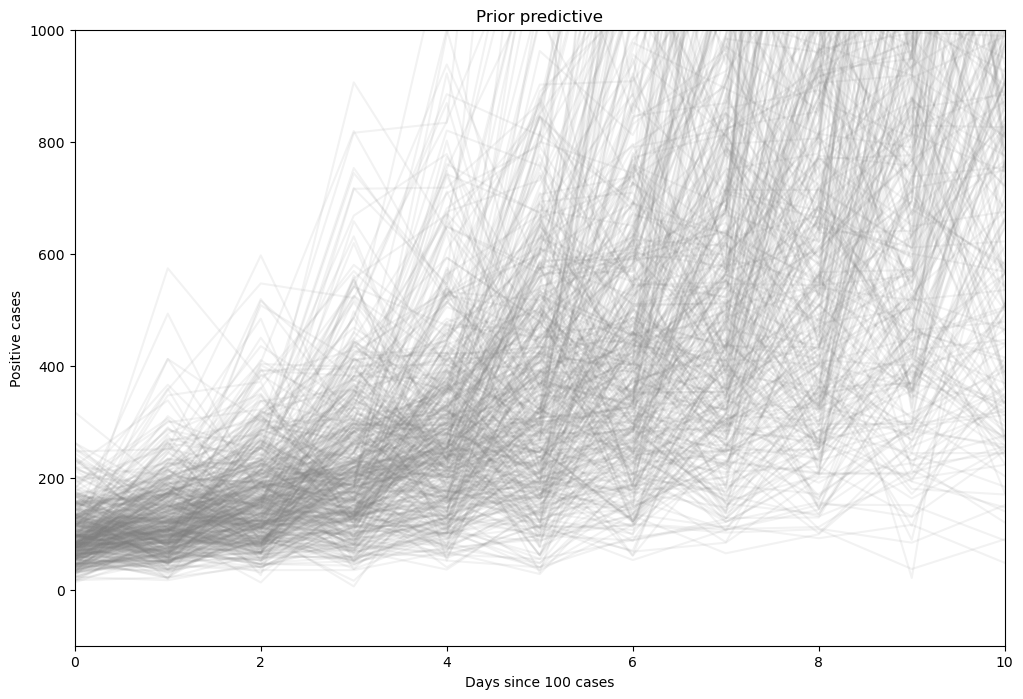

In [35]:
with model_exp2:
    prior_pred = pm.sample_prior_predictive()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred.prior_predictive['obs'].values.squeeze().T, color="0.5", alpha=.1)
ax.set(ylim=(-100, 1000),
       xlim=(0, 10),
       title="Prior predictive",
       xlabel="Days since 100 cases",
       ylabel="Positive cases");

### 4. Fit model

In [36]:
with model_exp2:
    trace_exp2 = pm.sample(chains=4, cores=4, tune=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, alpha]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


### 5. Assess convergence

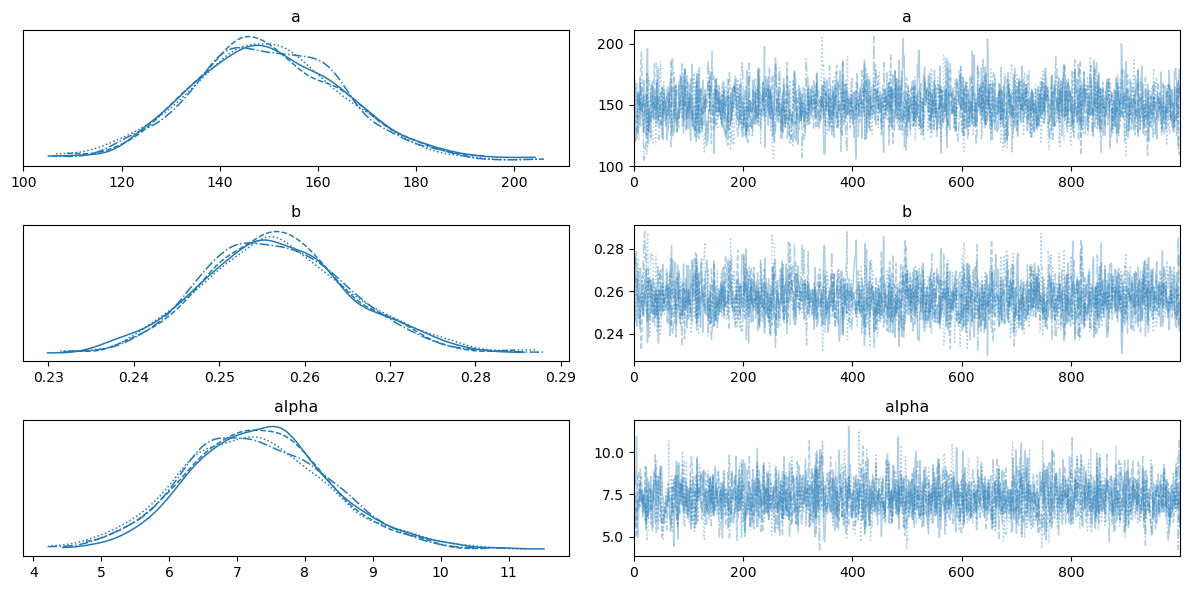

In [37]:
az.plot_trace(trace_exp2, var_names=['a', 'b', 'alpha'])
plt.tight_layout();

In [38]:
az.summary(trace_exp2, var_names=['a', 'b', 'alpha'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,149.570,15.126,121.626,178.406,0.342,0.250,1943.0,1743.0,1.0
b,0.257,0.009,0.240,0.274,0.000,0.000,1900.0,1644.0,1.0
alpha,7.304,1.060,5.229,9.260,0.023,0.018,2214.0,2362.0,1.0


In [ ]:
az.plot_energy(trace_exp2);

### 6. Run posterior predictive check

In [40]:
with model_exp2:
    # Draw sampels from posterior predictive
    post_pred = pm.sample_posterior_predictive(trace_exp2.posterior)

Sampling: [obs]


Output()

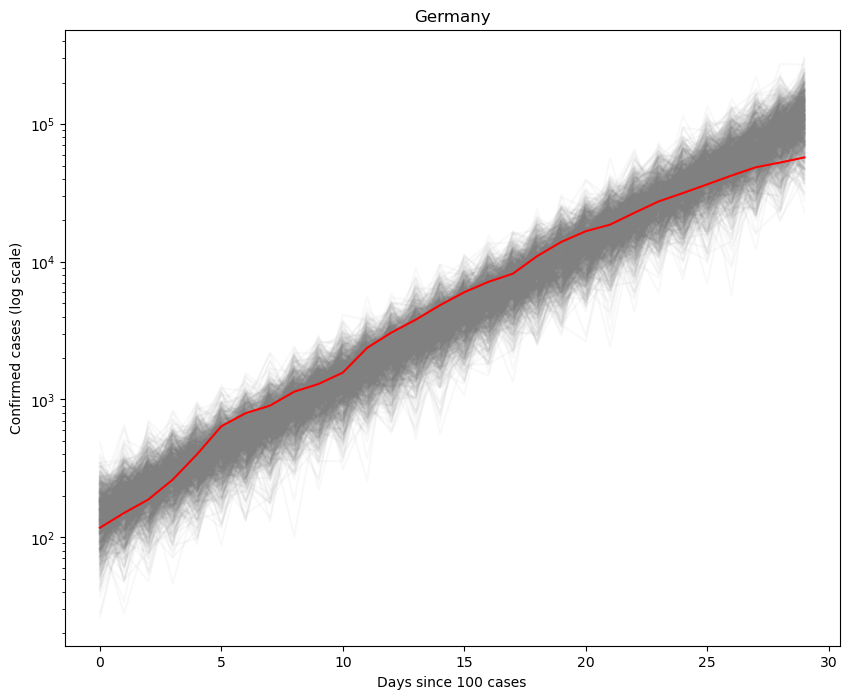

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(post_pred.posterior_predictive['obs'].sel(chain=0).values.squeeze().T, color='0.5', alpha=.05)
ax.plot(confirmed, color='r', label='data')
ax.set(xlabel="Days since 100 cases", 
       ylabel="Confirmed cases (log scale)",
       title=country, 
       yscale="log");

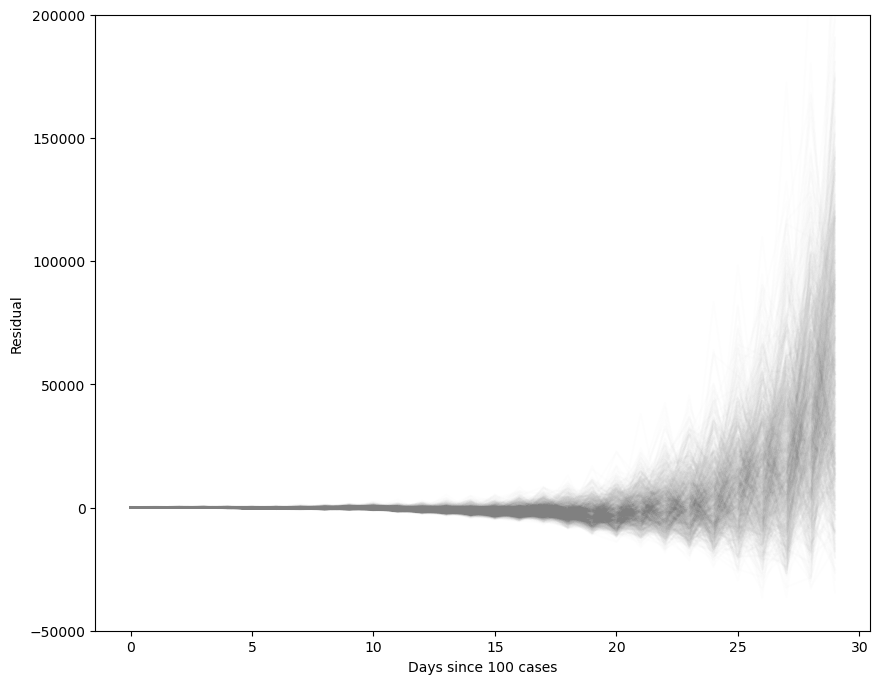

In [42]:
fig, ax = plt.subplots(figsize=(10, 8))
resid = post_pred.posterior_predictive["obs"].sel(chain=0) - confirmed
ax.plot(resid.T, color="0.5", alpha=.01);
ax.set(ylim=(-50_000, 200_000), ylabel="Residual",
       xlabel="Days since 100 cases");

### 7. Improve model - Logistic Growth Model

The exponential model doesn't capture the plateau in cases that we expect to see over time. Let's implement a logistic growth model which has an S-shaped curve that better represents epidemic dynamics with a carrying capacity.

In [43]:
df_country = df.query(f'country=="{country}"').loc[:date]

with pm.Model() as logistic_model:
    t_data = pm.Data('t', df_country.days_since_100.values)
    confirmed_data = pm.Data('confirmed', df_country.confirmed.values)

    # Intercept
    a0 = pm.HalfNormal('a0', sigma=25)
    intercept = pm.Deterministic('intercept', a0 + 100)

    # Slope
    b = pm.HalfNormal('b', sigma=0.2)
    
    carrying_capacity = pm.Uniform('carrying_capacity',
                                   lower=1_000,
                                   upper=80_000_000)
    # Transform carrying_capacity to a
    a = carrying_capacity / intercept - 1

    # Logistic
    growth = carrying_capacity / (1 + a * pm.math.exp(-b * t_data))

    # Likelihood
    pm.NegativeBinomial('obs',
                 growth,
                 alpha=pm.Gamma("alpha", mu=6, sigma=1),
                 observed=confirmed_data)

In [44]:
with logistic_model:
    prior_pred = pm.sample_prior_predictive()

Sampling: [a0, alpha, b, carrying_capacity, obs]


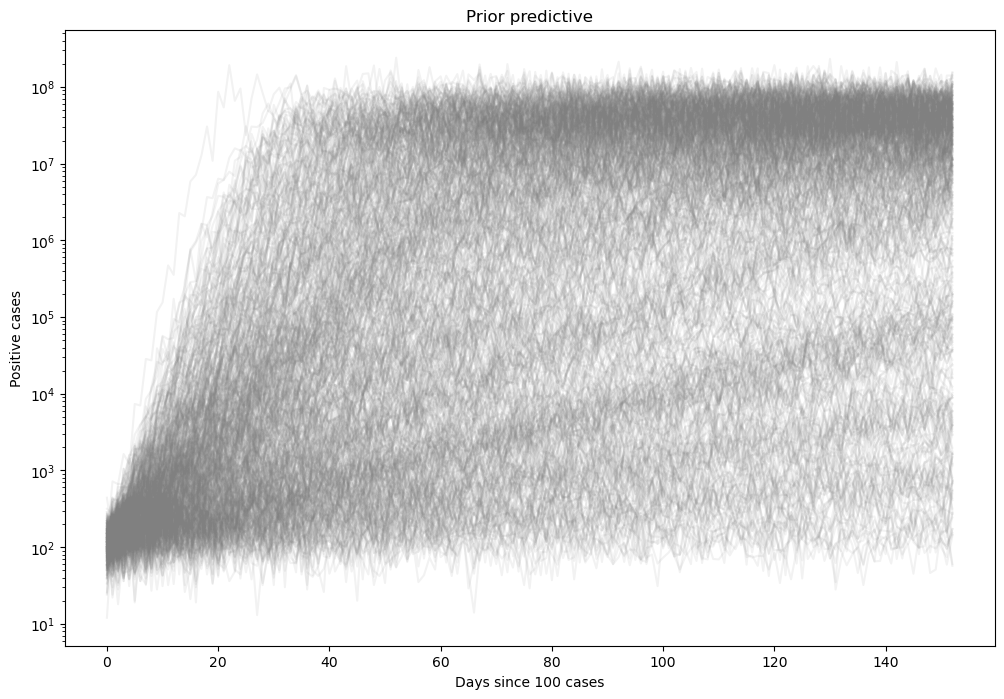

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred.prior_predictive['obs'].squeeze().values.T, color="0.5", alpha=.1)
ax.set(title="Prior predictive",
       xlabel="Days since 100 cases",
       ylabel="Positive cases",
       yscale="log",
);

In [46]:
with logistic_model:
    # Inference
    trace_logistic = pm.sample(chains=4, cores=4, tune=2000, target_accept=0.9)
    
    # Sample posterior predcitive
    pm.sample_posterior_predictive(trace_logistic, extend_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, b, carrying_capacity, alpha]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.
Sampling: [obs]


Output()

In [ ]:
az.plot_trace(trace_logistic)
plt.tight_layout();

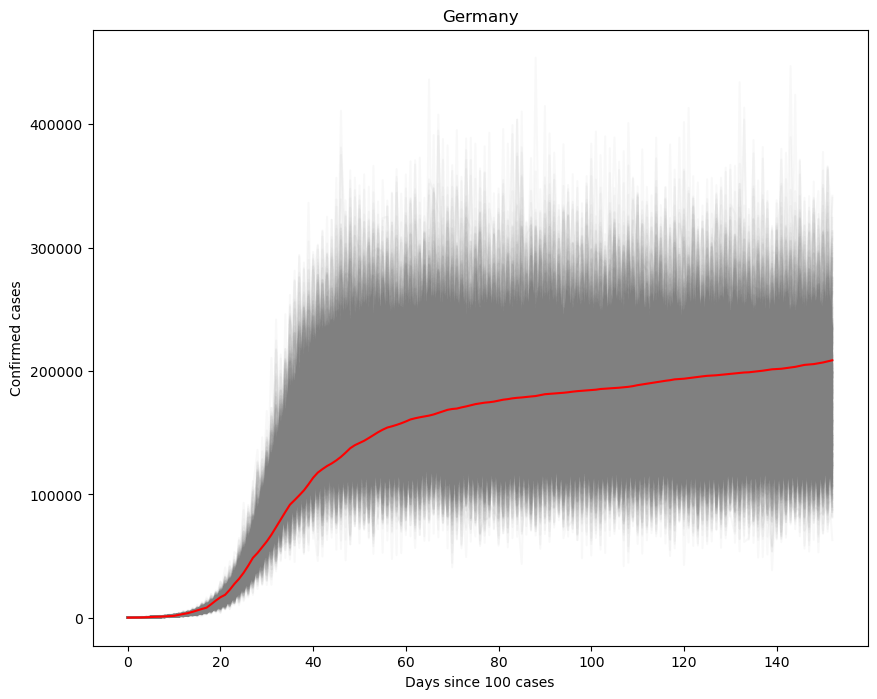

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(trace_logistic.posterior_predictive['obs'].sel(chain=0).squeeze().values.T, color='0.5', alpha=.05)
ax.plot(df_country.confirmed.values, color='r')
ax.set(xlabel='Days since 100 cases', ylabel='Confirmed cases',
       title=country);

In [49]:
# Compare models using WAIC or LOO
with model_exp2:
    pm.compute_log_likelihood(trace_exp2)

with logistic_model:
    pm.compute_log_likelihood(trace_logistic)

az.plot_compare(az.compare({"exp2": trace_exp2, 
            "logistic": trace_logistic}))

Output()

Output()

ValueError: The number of observations should be the same across all models

### Forecasting

One of the key strengths of Bayesian modeling is the ability to make predictions with uncertainty. Let's extend our prediction window to forecast future cases.

In [ ]:
# Create a forecast window
forecast_days = 60  # 2 months forecast
future_days = np.arange(len(df_country.days_since_100.values), 
                        len(df_country.days_since_100.values) + forecast_days)

with logistic_model:
    # Update our data containers for forecasting
    pm.set_data({'t': np.concatenate([df_country.days_since_100.values, future_days]),
                 'confirmed': np.concatenate([df_country.confirmed.values, 
                                            np.zeros(forecast_days, dtype='int')])})

    forecast = pm.sample_posterior_predictive(trace_logistic)

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Extract data for plotting
historical_days = len(df_country.days_since_100.values)
all_days = np.arange(historical_days + forecast_days)

# Calculate forecast statistics
forecast_samples = forecast.posterior_predictive['obs'].values
forecast_mean = forecast_samples.mean(axis=(0, 1))
forecast_lower = np.percentile(forecast_samples, 2.5, axis=(0, 1))
forecast_upper = np.percentile(forecast_samples, 97.5, axis=(0, 1))

# Create figure
fig = go.Figure()

# Add observed data
fig.add_trace(
    go.Scatter(
        x=np.arange(historical_days),
        y=df_country.confirmed.values,
        mode='lines+markers',
        name='Observed cases',
        line=dict(color='black', width=2),
        marker=dict(size=6)
    )
)

# Add forecast mean
fig.add_trace(
    go.Scatter(
        x=all_days,
        y=forecast_mean,
        mode='lines',
        name='Mean forecast',
        line=dict(color='blue', width=2)
    )
)

# Add prediction interval
fig.add_trace(
    go.Scatter(
        x=np.concatenate([all_days, all_days[::-1]]),
        y=np.concatenate([forecast_upper, forecast_lower[::-1]]),
        fill='toself',
        fillcolor='rgba(0, 0, 255, 0.2)',
        line=dict(color='rgba(255, 255, 255, 0)'),
        name='95% credible interval'
    )
)

# Add vertical line to separate historical data from forecast
fig.add_shape(
    type="line",
    x0=historical_days-1, x1=historical_days-1,
    y0=0, y1=forecast_mean[historical_days-1],
    line=dict(color='gray', width=2, dash='dash')
)

# Add annotation for forecast beginning
fig.add_annotation(
    x=historical_days+5,
    y=forecast_mean[historical_days-1],
    text="Forecast begins",
    showarrow=True,
    arrowhead=2,
    arrowsize=1,
    arrowwidth=2,
    arrowcolor="black",
    ax=-40,
    ay=0
)

# Update layout
fig.update_layout(
    title=f'COVID-19 Cases Forecast for {country}',
    xaxis=dict(
        title='Days since 100 cases'
    ),
    yaxis=dict(
        title='Confirmed cases'
    ),
    width=1200,
    height=800,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

## Summary: The Bayesian Workflow

1. **Exploratory Data Analysis**
   - Plot your data
   - Identify patterns and potential model structures

2. **Model Specification**
   - Choose appropriate likelihood function
   - Specify prior distributions
   - Think about the generative process

3. **Prior Predictive Checks**
   - Simulate from your priors
   - Check if simulated data matches your understanding of the domain

4. **Model Fitting**
   - Use appropriate MCMC methods (NUTS, etc.)
   - Consider computational efficiency (parameterization)

5. **Convergence Checks**
   - Examine trace plots
   - Check R-hat statistics
   - Monitor effective sample size
   - Watch for divergences

6. **Posterior Predictive Checks**
   - Can the model reproduce the observed data?
   - Check residuals
   - Look for systematic errors

7. **Model Comparison and Selection**
   - Compare multiple models using WAIC, LOO, etc.
   - Balance complexity and fit

8. **Forecasting and Inference**
   - Use the model to answer research questions
   - Make predictions with uncertainty
   - Interpret results in the context of the domain

9. **Iterate and Improve**
   - Refine models based on checks
   - Consider alternative structures
   - Add more complexity as needed

---

## References

Gelman, A., Carlin, J. B., Stern, H. S., & Rubin, D. B. (2003). Bayesian Data Analysis, Second Edition (Chapman & Hall/CRC Texts in Statistical Science) (2nd ed.). Chapman and Hall/CRC.

Gelman, A., & Rubin, D. B. (1992). Inference from iterative simulation using multiple sequences. Statistical Science. A Review Journal of the Institute of Mathematical Statistics, 457–472.

Vehtari, A., Gelman, A., Simpson, D., Carpenter, B., & Bürkner, P.-C. (2019). Rank-normalization, folding, and localization: An improved $\hat{R}$ for assessing convergence of MCMC. arXiv preprint arXiv:1903.08008.

Gelman, A., Hwang, J., & Vehtari, A. (2014). Understanding predictive information criteria for Bayesian models. Statistics and Computing, 24(6), 997–1016.

Betancourt, M. (2016). Diagnosing Suboptimal Cotangent Disintegrations in Hamiltonian Monte Carlo. arXiv preprint arXiv:1604.00695.

Gabry, J., Simpson, D., Vehtari, A., Betancourt, M., & Gelman, A. (2019). Visualization in Bayesian workflow. Journal of the Royal Statistical Society: Series A (Statistics in Society), 182(2), 389-402.